In [1]:
import os
os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices=false" # 关闭部分 XLA 行为
os.environ["TF_CUDNN_DETERMINISTIC"] = "1" # 强制确定性算法，减少搜索

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import KFold
import itertools


2025-12-15 10:26:49.985598: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-15 10:26:50.017601: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-15 10:26:50.730900: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
# 1. 确保显存按需分配（防止 OOM）
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✅ 已开启显存按需分配模式")
    except RuntimeError as e:
        print(e)

✅ 已开启显存按需分配模式


#### Data Preparation and Preprocessing
load and normalize images

In [4]:
import tensorflow as tf

# Define dataset paths
train_dir = "/home/zyh/Fruit-Classifier/data/train_augment"    # directory with subfolders for each class (train set)


IMG_SIZE = 224   # image size (can be adjusted as needed)



model structure

In [5]:
from tensorflow.keras import layers, models, regularizers

def create_cnn_model(activation='relu', dropout_rate=0.2, l2_rate=0.0):
    model = models.Sequential()
    # Convolutional layers with chosen activation and optional L2 regularization
    model.add(layers.Conv2D(32, (3,3), padding='same', activation=activation, 
                             input_shape=(IMG_SIZE, IMG_SIZE, 3),
                             kernel_regularizer=regularizers.l2(l2_rate)))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(64, (3,3), padding='same', activation=activation,
                             kernel_regularizer=regularizers.l2(l2_rate)))
    model.add(layers.MaxPooling2D(pool_size=2))
    model.add(layers.Conv2D(128, (3,3), padding='same', activation=activation,
                             kernel_regularizer=regularizers.l2(l2_rate)))
    model.add(layers.MaxPooling2D(pool_size=2))
    # Flatten and Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation=activation, 
                            kernel_regularizer=regularizers.l2(l2_rate)))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(32, activation=activation, 
                            kernel_regularizer=regularizers.l2(l2_rate)))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(4, activation='softmax'))  # 4 output classes
    return model

As shown above, we parameterize the activation function, dropout rate, and L2 regularization rate so that these can be tuned. By default, the original model used ReLU activations and a dropout rate of 0.2 in two places. We include the option to use Leaky ReLU as an alternative; if Leaky ReLU is selected, we will insert layers.LeakyReLU() layers after each linear layer (since Keras layers.Dense or Conv2D do not accept leaky_relu string directly, we would use activation=None and add a LeakyReLU layer manually).

Regularization: We have two forms of regularization to consider – dropout and L2 weight decay. Dropout randomly zeros out a fraction of neurons during training to prevent co-adaptation of features, while L2 penalizes large weights. Both are known to help reduce overfitting. In the model, dropout layers are included as shown; L2 regularization is applied to convolutional and dense layers via kernel_regularizer=regularizers.l2(l2_rate). We will tune the dropout_rate (e.g., try values like 0.0 = no dropout vs 0.5) and the l2_rate (e.g., 0.0 = no L2 vs a small value like 0.001) as hyperparameters.

Initially, we keep other aspects constant (the number of layers/units as given). The model will be compiled with a chosen optimizer and learning rate (also to be tuned). For example, using Adam optimizer with a certain learning rate as in the original code:

In [6]:
# model = create_cnn_model(activation='relu', dropout_rate=0.2, l2_rate=0.0)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)  # example learning rate
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


#### Hyperparameter Tuning with Grid Search and K-Fold Cross-Validation

To systematically find the best hyperparameter combination, we employ grid search over the specified hyperparameter ranges, coupled with K-fold cross-validation for robust evaluation. Grid search will exhaustively try all combinations of the provided hyperparameters, and K-fold CV means that for each combination, the training data is further split into K folds to evaluate the model’s performance across different subsets. This helps ensure the hyperparameter choice generalizes well and is not overfitting to one particular train/validation split.

Hyperparameters to tune:

Learning Rate: We will search values in the range 0.1 to 0.001. Given the prompt’s suggestion, we use a logarithmic scale: e.g. [0.1, 0.01, 0.001]. 

Optimizer: We consider two optimizers – Stochastic Gradient Descent (SGD) and Adam. These represent different update algorithms; SGD could be used with momentum, but here we’ll use plain SGD vs Adam.

Batch Size: Try [16, 32, 64]. Batch size affects training stability and speed.

Activation Function: Either ReLU or LeakyReLU. We will implement LeakyReLU with a negative slope (default 0.2) if chosen.

Dropout Rate: Try e.g. [0.0, 0.5] – either no dropout or 50% dropout. (We could also test an intermediate like 0.2 as in the original.)

L2 Regularization (weight decay) factor: Try [0.0, 0.001] – either no L2 penalty or a small penalty.

Given these choices, the grid has 3×2×3×2×2×2 = 144 possible combinations.  For demonstration, let's set K = 5 (5-fold cross-validation) by default.


正在加载数据到内存: /home/zyh/Fruit-Classifier/data/train_augment ...
检测到的类别: ['apple', 'banana', 'mixed', 'orange']
数据加载完成! X shape: (308, 224, 224, 3), y shape: (308, 4)

🚀 Starting Grid Search (Target: Minimum Validation Loss)
Total combinations: 24 (with 5-Fold CV)

👉 [1/24] Testing: {'learning_rate': 0.001, 'optimizer_name': 'SGD', 'batch_size': 16, 'activation': 'relu', 'dropout_rate': 0.2} ...

/home/zyh/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1765765616.610045 1364597 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-12-15 10:26:57.859292: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91600


 -> Loss: 1.3269 (±0.0448)
   🔥 New Best Model found! (Low Loss: 1.3269)
👉 [2/24] Testing: {'learning_rate': 0.001, 'optimizer_name': 'SGD', 'batch_size': 16, 'activation': 'relu', 'dropout_rate': 0.4} ... -> Loss: 1.3757 (±0.0164)
👉 [3/24] Testing: {'learning_rate': 0.001, 'optimizer_name': 'SGD', 'batch_size': 32, 'activation': 'relu', 'dropout_rate': 0.2} ... -> Loss: 1.3565 (±0.0084)
👉 [4/24] Testing: {'learning_rate': 0.001, 'optimizer_name': 'SGD', 'batch_size': 32, 'activation': 'relu', 'dropout_rate': 0.4} ... -> Loss: 1.3617 (±0.0221)
👉 [5/24] Testing: {'learning_rate': 0.001, 'optimizer_name': 'Adam', 'batch_size': 16, 'activation': 'relu', 'dropout_rate': 0.2} ... -> Loss: 0.6891 (±0.1968)
   🔥 New Best Model found! (Low Loss: 0.6891)
👉 [6/24] Testing: {'learning_rate': 0.001, 'optimizer_name': 'Adam', 'batch_size': 16, 'activation': 'relu', 'dropout_rate': 0.4} ... -> Loss: 0.5362 (±0.2012)
   🔥 New Best Model found! (Low Loss: 0.5362)
👉 [7/24] Testing: {'learning_rate': 0.

/tmp/ipykernel_1364597/397811897.py:151: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Label', y='mean_loss', data=df_results, palette='viridis', ci=None)
/tmp/ipykernel_1364597/397811897.py:151: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Label', y='mean_loss', data=df_results, palette='viridis', ci=None)


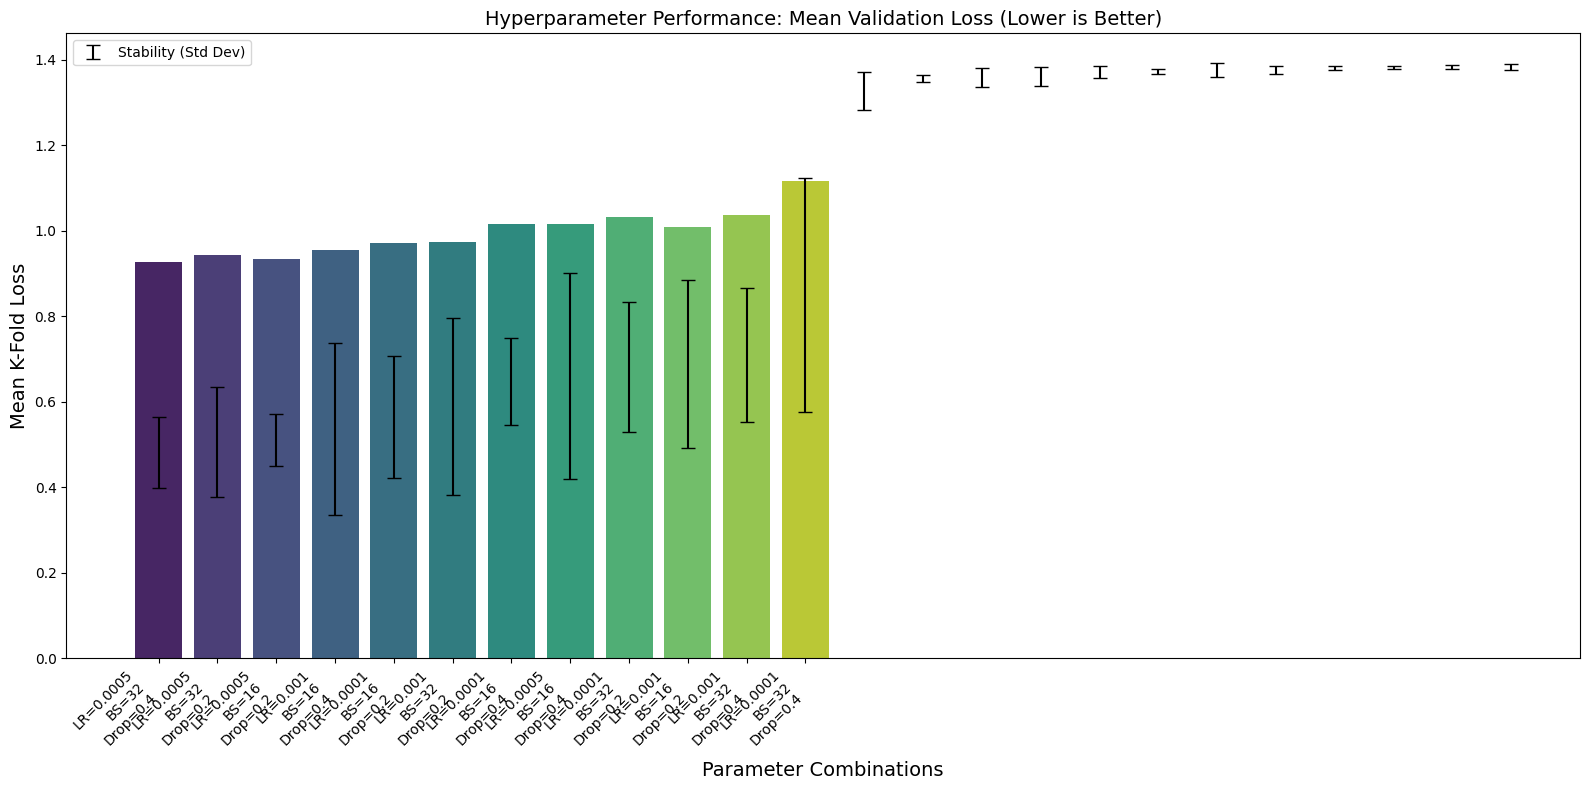


 Chart Guide:
1. Height of bar: Average Loss (Lower is better).
2. Black line (Error Bar): Stability. Shorter lines mean the model is more stable across different data splits.


In [7]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Wrap the model creation in KerasClassifier for use in GridSearchCV
def build_model(learning_rate=0.01, optimizer_name='Adam', activation='relu', 
                dropout_rate=0.2, l2_rate=0.0):
    # Build the CNN model with given hyperparams
    model = create_cnn_model(activation=activation, dropout_rate=dropout_rate, l2_rate=l2_rate)
    # Choose optimizer
    if optimizer_name == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:  # 'SGD'
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'], jit_compile=False)
    return model


# 全内存数据加载函数 (速度优化的关键)
def load_data_to_memory(data_dir, img_size):
    print(f"正在加载数据到内存: {data_dir} ...")
    X = []
    y = []
    # 确保类名顺序一致: ['apple', 'banana', 'mixed', 'orange']
    classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    print(f"检测到的类别: {classes}")
    
    for label_idx, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        files = os.listdir(class_dir)
        for fname in files:
            if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                fpath = os.path.join(class_dir, fname)
                # 加载并调整大小
                img = load_img(fpath, target_size=(img_size, img_size))
                # 转为数组并归一化 (0-1)
                img_array = img_to_array(img) / 255.0
                
                X.append(img_array)
                y.append(label_idx)
                
    X = np.array(X)
    # 将标签转为 One-hot 编码 (e.g., [0, 1, 0, 0])
    y = tf.keras.utils.to_categorical(np.array(y), num_classes=len(classes))
    print(f"数据加载完成! X shape: {X.shape}, y shape: {y.shape}")
    return X, y



# 一次性读取所有数据到 RAM (320张图约占用 150MB~200MB 内存，非常安全)
X_all, y_all = load_data_to_memory(train_dir, IMG_SIZE)


#  极速版 Grid Search
param_grid = {
    'learning_rate': [0.001, 0.0005,0.0001],
    'optimizer_name': ['SGD', 'Adam'],
    'batch_size': [16, 32],
    'activation': ['relu'],
    'dropout_rate': [0.2,0.4],
    #'l2_rate': [0.0, 0.001]
}

combinations = list(itertools.product(*param_grid.values()))
total_runs = len(combinations)
keys = list(param_grid.keys())

# Storage for results
experiment_results = []
best_loss = float('inf') # Finding Minimum
best_params = {}

print(f"\n🚀 Starting Grid Search (Target: Minimum Validation Loss)")
print(f"Total combinations: {total_runs} (with 5-Fold CV)\n")

# Use 5-Fold as requested
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

for run_idx, combo in enumerate(combinations):
    params = dict(zip(keys, combo))
    # Extract batch_size
    build_args = {k: v for k, v in params.items() if k != 'batch_size'}
    current_batch_size = params['batch_size']
    
    fold_losses = []
    fold_accs = []
    
    print(f"👉 [{run_idx+1}/{total_runs}] Testing: {params} ...", end="", flush=True)
    
    for train_idx, val_idx in kfold.split(X_all):
        tf.keras.backend.clear_session() # Clear GPU memory
        
        X_train, X_val = X_all[train_idx], X_all[val_idx]
        y_train, y_val = y_all[train_idx], y_all[val_idx]
        
        model = build_model(**build_args)
        
        # Training
        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=current_batch_size,
            epochs=15, 
            callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=False, monitor='val_loss')],
            verbose=0 # Silent mode for speed
        )
        
        # Evaluation
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
        fold_losses.append(val_loss)
        fold_accs.append(val_acc)
        


    # Calculate Statistics
    mean_loss = np.mean(fold_losses)
    std_loss = np.std(fold_losses)
    mean_acc = np.mean(fold_accs)
    
    print(f" -> Loss: {mean_loss:.4f} (±{std_loss:.4f})")
    
    # Store results
    res_entry = params.copy()
    res_entry['mean_loss'] = mean_loss
    res_entry['std_loss'] = std_loss
    res_entry['mean_acc'] = mean_acc
    # Create short label for plotting
    res_entry['Label'] = f"LR={params['learning_rate']}\nBS={params['batch_size']}\nDrop={params['dropout_rate']}"
    experiment_results.append(res_entry)

    # Check for best (Minimum Loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        best_params = params
        print(f"   🔥 New Best Model found! (Low Loss: {best_loss:.4f})")

print("\n================ Search Complete ================")
print(f"Best Loss: {best_loss:.4f}")
print(f"Best Params: {best_params}")


# 4. Visualization 
if len(experiment_results) > 0:
    df_results = pd.DataFrame(experiment_results)
    
    # Sort by mean loss for better visualization
    df_results = df_results.sort_values(by='mean_loss', ascending=True)
    
    plt.figure(figsize=(16, 8))
    
    # Bar plot for Mean Loss
    sns.barplot(x='Label', y='mean_loss', data=df_results, palette='viridis', ci=None)
    
    # Add Error Bars (Standard Deviation)
    plt.errorbar(x=range(len(df_results)), 
                 y=df_results['mean_loss'], 
                 yerr=df_results['std_loss'], 
                 fmt='none', c='black', capsize=5, label='Stability (Std Dev)')
    
    plt.title('Hyperparameter Performance: Mean Validation Loss (Lower is Better)', fontsize=14)
    plt.ylabel('Mean K-Fold Loss', fontsize=14)
    plt.xlabel('Parameter Combinations', fontsize=14)
    plt.xticks(rotation=45,ha='right', fontsize=10)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print("\n Chart Guide:")
    print("1. Height of bar: Average Loss (Lower is better).")
    print("2. Black line (Error Bar): Stability. Shorter lines mean the model is more stable across different data splits.")

A few notes on the above:

We defined build_model to accept the hyperparams. If activation='leaky_relu', inside create_cnn_model we would handle that by setting layers with no activation and adding LeakyReLU layers. (This implementation detail can be handled with an if inside create_cnn_model.)


------------------------------------------------------

 Ideally, each fold’s training could stop early if the model’s performance on that fold’s validation subset stops improving. The scikit-learn wrapper does not directly use the K-fold partition as a Keras validation in each fit call. A workaround is to use validation_split within each fold’s training or to manually perform the cross-validation loop. In our case, we set a relatively small number of epochs (10) for each training, assuming this is sufficient to evaluate performance without severe overfitting. If we wanted to incorporate early stopping in GridSearchCV, we could pass a callback through the fit_params. For example:

In [8]:
# from tensorflow.keras.callbacks import EarlyStopping
# early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# grid_search.fit(X_train, y_train, **{'callbacks': [early_stop], 'validation_split': 0.1})


This would use 10% of each fold’s training data as a validation for early stopping. However,  this means we’re not fully using that 10% for training in each fold (since it’s used as a temp validation), and the actual cross-val fold (held-out by GridSearch) isn’t directly used for early stopping. Due to these complexities, one might simply keep epochs low or perform manual K-fold training to properly utilize each fold’s validation. Given our epoch count is modest (10) and we have early stopping for the final training phase, we can omit early stopping during the grid search phase to simplify.

-------------------------------------------------------

#### Model Training with Best Hyperparameters and Early Stopping

In [9]:
# # Build final model with best hyperparams
# best_model = create_cnn_model(activation=best_params['activation'], 
#                               dropout_rate=best_params['dropout_rate'], 
#                               l2_rate=best_params['l2_rate'])
# if best_params['optimizer_name'] == 'Adam':
#     final_optimizer = tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate'])
# else:
#     final_optimizer = tf.keras.optimizers.SGD(learning_rate=best_params['learning_rate'])
# best_model.compile(optimizer=final_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# # Setup callbacks for early stopping (and optional learning rate reduction, checkpoints as in original code)
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
#     ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1),
#     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
# ]

# # Train the model with early stopping
# history = best_model.fit(train_generator, epochs=50,  # start with an upper bound, early stopping will likely stop earlier
#                          validation_data=val_generator, 
#                          callbacks=callbacks, verbose=1)


Results and Visualization of Training Progress

In [10]:
# val_loss, val_acc = best_model.evaluate(val_generator)
# print(f"Validation Accuracy: {val_acc:.2%}, Validation Loss: {val_loss:.4f}")


In [11]:
# import matplotlib.pyplot as plt

# # Extract history data
# epochs = range(1, len(history.history['loss'])+1)
# train_loss = history.history['loss']
# val_loss = history.history['val_loss']
# train_acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# # Plot Loss Curves
# plt.figure(figsize=(6,4))
# plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
# plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
# plt.title('Training vs Validation Loss')
# plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.show()

# # Plot Accuracy Curves
# plt.figure(figsize=(6,4))
# plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
# plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
# plt.title('Training vs Validation Accuracy')
# plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.show()
